In [1]:
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
import ipywidgets as ipywidg
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
import math
import scipy.optimize as optimize
%matplotlib inline
import matplotlib.pylab as pylab
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

Внизу приведены примеры для нескольких случаев

In [2]:
#Golub-Kahan-Lanczos Bidiagonalization Procedure.   High-triangular
def GKLBi_procedure(A):
    #print(A.shape[0])
    #print(A.shape[1])
    v = np.zeros(A.shape[1])
    u = np.zeros(A.shape[0])
    beta = 0
    v[0] = 1
    #print(v)
    #print(A.dot(v))
    #V_matrix = np.zeros((A.shape[1], A.shape[1]))
    V_matrix = []
    U_matrix = []
    #U_matrix = np.zeros((A.shape[0], A.shape[1]))
    V_matrix.append(v)
    L = np.zeros((A.shape[1], A.shape[1]))
    #V_matrix = np.append(V_matrix, v)
    for k in range(1, A.shape[1] + 1):
        u = A.dot(v) - beta * u
        #print(u)
        alpha = np.linalg.norm(u, 2)
        #print(alpha)
        u = u / alpha
        U_matrix.append(u)
        #U_matrix = np.append(U_matrix, u)
        v = A.T.dot(u) - alpha * v
        beta = np.linalg.norm(v, 2)
        v = v/beta
        #print("This is v", v)
        if(k != A.shape[1]):
            V_matrix.append(v)
        L[k-1][k-1] = alpha
        if(k != A.shape[1]):
            L[k-1][k] = beta
        #V_matrix = np.append(V_matrix, v)
    V_matrix = np.array(V_matrix)
    U_matrix = np.array(U_matrix).T
    print("V", V_matrix)
    print("U", U_matrix)
    #print("ULV", V_matrix.dot(L.T.dot(V_matrix)))
    #return U_matrix, L, V_matrix
    #L = U_matrix.T.dot(A.dot(V_matrix))
    #print(U_matrix.dot(A.dot(V_matrix)))
    #print("L", L)
    #print("U*U", U_matrix.T.dot(U_matrix))
    print("ULV", U_matrix.dot(L.dot(V_matrix)))
    #print(U_matrix.T.dot(L.dot(V_matrix)))
Z = np.array([[1, 2],
              [2, 3],
              [3, 5]])
Z = np.reshape(Z, (3,2))
print(Z)
GKLBi_procedure(Z)

[[1 2]
 [2 3]
 [3 5]]
V [[1. 0.]
 [0. 1.]]
U [[ 0.26726124  0.77151675]
 [ 0.53452248 -0.6172134 ]
 [ 0.80178373  0.15430335]]
ULV [[1. 2.]
 [2. 3.]
 [3. 5.]]


In [3]:
#Golub-Kahan-Lanczos Bidiagonalization Procedure.   Lower-triangular
import numpy as np
import scipy.sparse as scsp
U = np.matrix([])

def GKL_(A):
    A = np.matrix(A)
    m,n = A.shape
    
    p = max(m, n)
    alpha = np.zeros(p)
    beta = np.zeros(p-1)
    U = np.zeros((p, m))  # in fact it's U.H
    V = np.zeros((p, n))  # in fact it's V.H
    # Transposed matrices are used for easier slicing
    U[0, 0] = 1
    
    for i in range(p):
        V[i] = A.H@U[i] - beta[i-1]*V[i-1]
        alpha[i] = np.linalg.norm(V[i])
        V[i] /= alpha[i]

        if i > p - 2: continue
        U[i+1] = A@V[i] - alpha[i]*U[i]
        beta[i] = np.linalg.norm(U[i+1])
        U[i+1] /= beta[i]
    U,V = map(np.matrix, (U, V))
    B = scsp.diags((alpha, beta), [0, -1]).toarray()    
    return U.H, B, V

U, B, V = GKL_(np.array([[1, 2, 1], 
                           [2, 3, 2], 
                           [3, 5, 3],
                           [2, 1, 5]]))
print(U)
print(B)
print(V)
                          

[[ 1.00000000e+00  5.20361465e-17 -3.73145497e-16 -3.59626182e-13]
 [ 0.00000000e+00  4.78364873e-01 -1.84393365e-01 -8.58583796e-01]
 [ 0.00000000e+00  7.65383797e-01 -3.91785738e-01  5.10579650e-01]
 [ 0.00000000e+00  4.30528386e-01  9.01389495e-01  4.62848408e-02]]
[[2.44948974e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.53424474e+00 2.39078768e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.30871044e+00 7.01390558e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.06242284e-01 1.30727101e-11]]
[[ 0.40824829  0.81649658  0.40824829]
 [ 0.26344752 -0.53356459  0.80368167]
 [-0.87403017  0.22054967  0.43293083]
 [-0.45962579 -0.62978056 -0.62619532]]


In [4]:
U.dot(B.dot(V))

matrix([[1., 2., 1.],
        [2., 3., 2.],
        [3., 5., 3.],
        [2., 1., 5.]])

## Three squares

$$x_{k+1} = \underset{y \in R^n}{argmin}\left(\frac{L}{2}||y - x_k||^2 + \frac{1}{2f_1(x_k)}\left[f_1^2(x_k) + ||F(x_k) + F'(x_k)(y - x_k)||^2\right]\right) $$

$$ T_{i_k} = (F'^TF + L2^{i_k}f_1(x))^{-1} \cdot (L2^{i_k}f_1(x)x + F'^TF'x  - F'^TF)$$

### Example f(x) - Rozenbrock

In [5]:
"""
Function F and its gradient
"""

def F_Rozenbrock(x):
    #print(F)
    #F[0] = x[0] - 1
    #print(F)
    F = np.zeros_like(x)
    for i, x_i in enumerate(x):
        F[i] = x[i] - 1 if i == 0 else x_i + 1 - 2 * (x[i-1])**2
        #print(i)
        #F[i] = x_i + 1 - 2(x[i - 1])**2 + 1
    #print (F)
    return F

def grad_F_Rozenbrock(x):
    x_len = x.shape[0]
    grad_f = np.eye(x.shape[0])
    #print(grad_f)
    for i, x_i in enumerate(x):
        if(i+1 < x.shape[0]):
            grad_f[i+1][i] = -4 * x_i
    #print(grad_f)
    return grad_f

def psi_operator(y, x, f_x, L, grad_F):
    psi_1 = 1/2 * np.linalg.norm(f_x, 2) + L/2 * np.linalg.norm(y - x, 2)**2
    psi_2 = 1/(2 * np.linalg.norm(f_x, 2)) * np.linalg.norm(f_x + grad_F.dot(y - x), 2)**2
    return psi_1 + psi_2
    

grad_F_Rozenbrock(np.array([1, 1, 1, 1, 1]))

F_Rozenbrock(np.zeros((5)))

array([-1.,  1.,  1.,  1.,  1.])

In [6]:
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
x0 = np.array([-1,1, 1, 1], dtype = np.float64)
step_size = 0.1
def F_Rozenbrock_for_gd(x):
    return np.linalg.norm(F_Rozenbrock(x), 2)**2
def grad_Rozenbrock_for_gd(x):
    grad_f = np.zeros_like(x)
    
    for i, x_i in enumerate(x):
        grad_f[i] = 1/2 * (x_i - 1) - 8 * x_i * (x[i + 1] - 2 * x_i**2 + 1) if i == 0 else 2 * (x_i - 2 * x[i - 1]**2 + 1) 
        - 8 * x_i * (x[i + 1] - 2 * x_i**2 + 1) if i < x.shape[0] - 1 else 2 * (x_i - 2 * x[i - 1]** 2 + 1)
    
    return grad_f


grad_Rozenbrock_for_gd(np.array([1, 1, 1, 1, 1]))


gradient_descent = methods.fo.GradientDescent(F_Rozenbrock_for_gd, grad_Rozenbrock_for_gd, ss.ConstantStepSize(step_size))
sol = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)

Maximum iteration exceeds!


In [7]:
x_convergence_gd = gradient_descent.get_convergence()

In [8]:
#x_convergence_gd

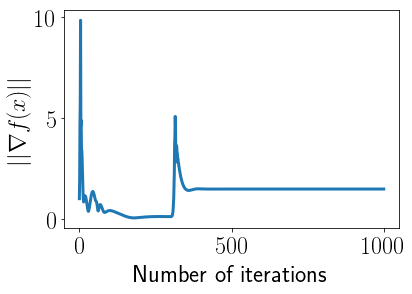

In [9]:
plt.plot([np.linalg.norm(grad_Rozenbrock_for_gd(x), 2) for x in x_convergence_gd])
#plt.plot()

plt.xlabel("Number of iterations")
plt.ylabel(r"$||\nabla f(x)||$")
plt.show()

In [10]:
gradient_descent_Armijo = methods.fo.GradientDescent(F_Rozenbrock_for_gd, grad_Rozenbrock_for_gd, 
            ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.))
sol = gradient_descent_Armijo.solve(x0, tol = 1e-6, max_iter = 1000)
x_convergence_gd_Armijo = gradient_descent_Armijo.get_convergence()

Maximum iteration exceeds!


In [11]:
#x_convergence_gd_Armijo

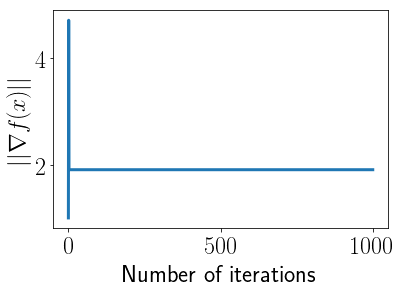

In [12]:
plt.plot([np.linalg.norm(grad_Rozenbrock_for_gd(x), 2) for x in x_convergence_gd_Armijo])
#plt.plot()

plt.xlabel("Number of iterations")
plt.ylabel(r"$||\nabla f(x)||$")
plt.show()

In [13]:
def TS_relaxation(x, L,f, grad_f, U, B, V):
    #i_arange = [0, 100]
    
    i = 0
    while(True):
        
        T_1 = V.T.dot(np.linalg.inv(L * 2**(i) * np.linalg.norm(f, 2) * np.eye(x.shape[0]) + B.T.dot(B)).dot(V))
        T_2 = V.T.dot(L * 2**(i) * np.linalg.norm(f, 2) * np.eye(x.shape[0]) + B.T.dot(B)).dot(V)
        T_3 = grad_f.T.dot(f)
        #print(T_1.shape)
        #print(T_2.shape)
        #print(T_3.shape)
        T_i = T_1.dot((T_2.dot(x) - T_3).T)
        
        #print(np.linalg.norm(F_Rozenbrock(T_i), 2) <= psi_operator(T_i, x, 2**(i) * L, grad_f))
        #print(i_arange)
        if(np.linalg.norm(F_Rozenbrock(T_i), 2) <= psi_operator(T_i, x, f, 2**(i) * L, grad_f)):
            #i_arange[1] = i
            return T_i, 2**(i - 1) * L
        else:
            i += 1
            #i_arange[0] = i
        #if(i_arange[1] < 1e-7):
        #    i_arange[1] = i_arange[0]
        #i = (i_arange[1] + i_arange[0]) / 2
        #i = round(i * 1e7) / 1e7
        #if(math.floor(i_arange[1] * 1e6) == math.floor(i_arange[0] * 1e6)):
            #return T_i, 2**(i - 1) * L
        


def three_squares(x_0, max_iter = 2):
    #initialization
    num_iter = 0
    x_convergence = []
    L_convergence = []
    x = x_0
    L = 1
    L_convergence.append(L)
    x_convergence.append(x)
    while(num_iter < max_iter):
        num_iter += 1
        
        grad_F = grad_F_Rozenbrock(x)
        U_k, B_k, V_k = GKL_(grad_F)
        
        T, L = TS_relaxation(x, L, F_Rozenbrock(x), grad_F, U_k, B_k, V_k)
        T = np.squeeze(np.asarray(T))
        
        x_convergence.append(T)
        L_convergence.append(L)
        
        if(np.linalg.norm(x - T, 2) <= 1e-6):
            return x_convergence, L_convergence, num_iter
        
        x = T
    print()
    return x_convergence, L_convergence, max_iter

In [14]:
x_0 = np.array([-1, 1, 1, 1, 1, 1, 1, 1, 1])
x_convergence, _, num_iter = three_squares(x_0, max_iter= 175)

In [15]:
#x_convergence

In [16]:
num_iter

122

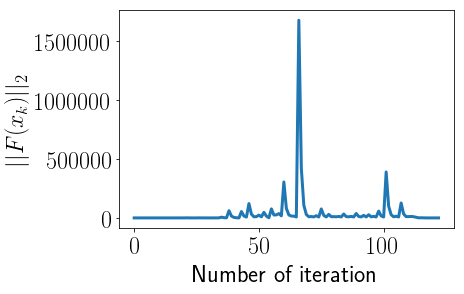

In [17]:
plt.plot([np.linalg.norm(F_Rozenbrock(x), 2) for x in x_convergence][:150])
plt.xlabel("Number of iteration")
plt.ylabel(r"$||F(x_k)||_2$")
plt.show()

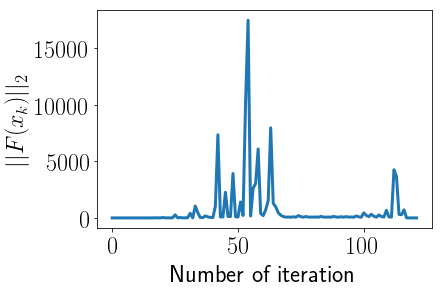

In [18]:
plt.plot([np.linalg.norm(x_convergence[i] - x_convergence[i - 1], 2) for i in range(1, len(x_convergence))])
plt.xlabel("Number of iteration")
plt.ylabel(r"$||F(x_k)||_2$")
plt.show()

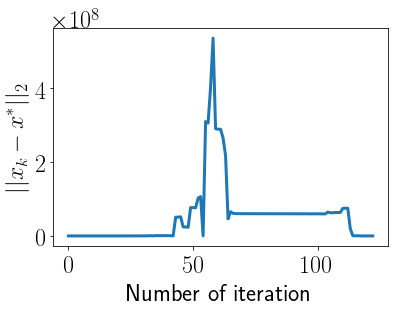

In [19]:
x_true = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
plt.plot([np.linalg.norm(x - x_true, 2)**2 for x in x_convergence])
plt.xlabel("Number of iteration")
plt.ylabel(r"$||x_k - x^*||_2$")
plt.show()

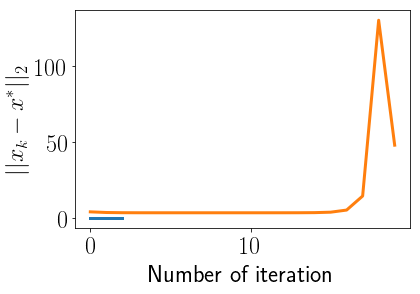

In [20]:
x_true = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
plt.plot([np.linalg.norm(x - x_true, 2)**2 for x in x_convergence][120:])
plt.plot([np.linalg.norm(x - x_true, 2)**2 for x in x_convergence][:20])
plt.xlabel("Number of iteration")
plt.ylabel(r"$||x_k - x^*||_2$")
plt.show()

### Случай $n = 2$

In [21]:
#Запуск алгоритмов
x0 = np.array([-1, 1], dtype = float)
x_true = np.array([1, 1], dtype = float)

solution_gd = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
x_convergence, _, num_iter = three_squares(x0, max_iter= 1000)

Maximum iteration exceeds!


In [22]:
print(f" GDCS: $\Delta x_k$ = {np.linalg.norm(solution_gd - x_true, 2)}")
print(f"TS:$\Delta x_k$ = {np.linalg.norm(x_convergence[-1] - x_true, 2)}")

 GDCS: $\Delta x_k$ = 0.9305093871422988
TS:$\Delta x_k$ = 0.0


In [23]:
print(f"GDCS: ||nabla f(x)|| = {np.linalg.norm(grad_Rozenbrock_for_gd(solution_gd))}")

GDCS: ||nabla f(x)|| = 1.4778433573565841


In [24]:
print(f"TS exceed {num_iter}")

TS exceed 10


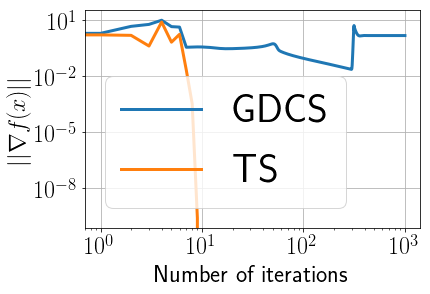

In [25]:
"""
Здесь строится сходимость по градиенту
"""


x_convergence_gd = gradient_descent.get_convergence()

plt.loglog([np.linalg.norm(grad_Rozenbrock_for_gd(x), 2) for x in x_convergence_gd], label = "GDCS")
plt.loglog([np.linalg.norm(grad_Rozenbrock_for_gd(x), 2) for x in x_convergence], label = "TS")
#plt.plot()

plt.xlabel("Number of iterations")
plt.ylabel(r"$||\nabla f(x)||$")
plt.grid()
plt.legend()
#plt.show()
plt.savefig("n2_roz_nabla.pdf")

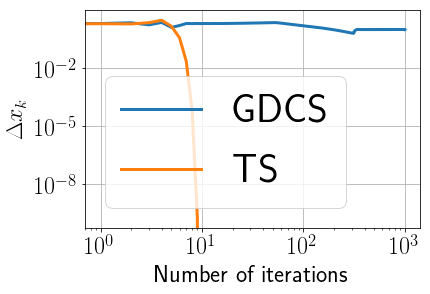

In [26]:
"""
Здесь строится сходимость по аргументу
"""

x_convergence_gd = gradient_descent.get_convergence()

plt.loglog([np.linalg.norm(x - x_true, 2) for x in x_convergence_gd], label = "GDCS")
plt.loglog([np.linalg.norm(x - x_true, 2) for x in x_convergence], label = "TS")
#plt.plot()

plt.xlabel("Number of iterations")
plt.ylabel(r"$\Delta x_k$")
plt.grid()
plt.legend()
#plt.show()
plt.savefig("n2_roz_delk.pdf")

In [27]:
#Время работы
%timeit gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
%timeit three_squares(x0, max_iter= 1000)

Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
M

### Случай $n = 4$

### Случай $n= 9$

In [28]:
#Запуск алгоритмов
x0 = np.array([-1, 1, 1, 1, 1, 1, 1, 1, 1], dtype = float)
x_true = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype = float)

solution_gd = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
x_convergence, _, num_iter = three_squares(x0, max_iter= 1000)

Maximum iteration exceeds!


In [29]:
solution_gd

array([ 0.67037761,  0.12982944, -0.97724683,  0.90526856,  0.64093613,
       -0.17894676, -0.93599945,  0.75217191,  0.13153119])

In [30]:
#Сколько сходились квадраты
num_iter

122

In [31]:
#Полученное решение
print(f" GDCS: $\Delta x_k$ = {np.linalg.norm(solution_gd - x_true, 2)}")
print(f"TS:$\Delta x_k$ = {np.linalg.norm(x_convergence[-1] - x_true, 2)}")

 GDCS: $\Delta x_k$ = 3.2965011450878534
TS:$\Delta x_k$ = 7.683411240577698e-09


In [32]:
#Итоговый градиент
print(f"GDCS: ||nabla f(x)|| = {np.linalg.norm(grad_Rozenbrock_for_gd(solution_gd))}")
print(f"TS: ||nabla f(x)|| = {np.linalg.norm(grad_Rozenbrock_for_gd(x_convergence[-1]))}")

GDCS: ||nabla f(x)|| = 1.4780418033980653
TS: ||nabla f(x)|| = 6.679764681968105e-08


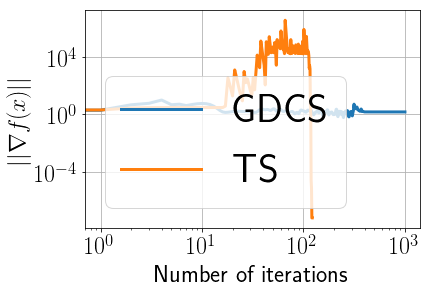

In [33]:
"""
Здесь строится сходимость по градиенту
"""

x_convergence_gd = gradient_descent.get_convergence()

plt.loglog([np.linalg.norm(grad_Rozenbrock_for_gd(x), 2) for x in x_convergence_gd], label = "GDCS")
plt.loglog([np.linalg.norm(grad_Rozenbrock_for_gd(x), 2) for x in x_convergence], label = "TS")
#plt.plot()

plt.xlabel("Number of iterations")
plt.ylabel(r"$||\nabla f(x)||$")
plt.grid()
plt.legend()
#plt.show()
plt.savefig("n9_roz_nabla.pdf")

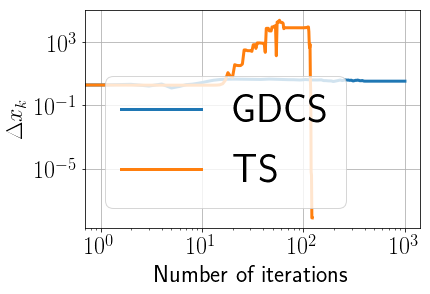

In [34]:
"""
Здесь строится сходимость по аргументу
"""

x_convergence_gd = gradient_descent.get_convergence()

plt.loglog([np.linalg.norm(x - x_true, 2) for x in x_convergence_gd], label = "GDCS")
plt.loglog([np.linalg.norm(x - x_true, 2) for x in x_convergence], label = "TS")
#plt.plot()

plt.xlabel("Number of iterations")
plt.ylabel(r"$\Delta x_k$")
plt.grid()
plt.legend()
#plt.show()
plt.savefig("n9_roz_delk.pdf")

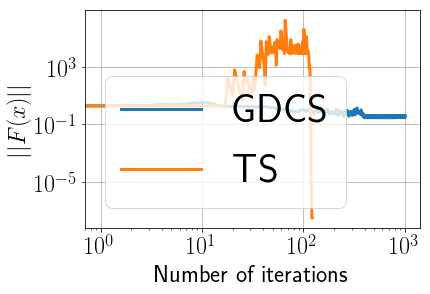

In [35]:
x_convergence_gd = gradient_descent.get_convergence()

plt.loglog([np.linalg.norm(F_Rozenbrock(x), 2) for x in x_convergence_gd], label = "GDCS")
plt.loglog([np.linalg.norm(F_Rozenbrock(x), 2) for x in x_convergence], label = "TS")
#plt.plot()

plt.xlabel("Number of iterations")
plt.ylabel(r"$||F(x)||$")
plt.grid()
plt.legend()
#plt.show()
plt.savefig("n9_roz_func.pdf")

In [36]:
%timeit gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
%timeit three_squares(x0, max_iter= 1000)

Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
Maximum iteration exceeds!
M

## Normalize Squares

In [37]:
def Normalized_f(x):
    return 1/x.shape[0]**(0.5) * F_Rozenbrock(x)


## Stochastic Squares